In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import warnings

import adcraft.baselines.interpolated_expectations as ie
import adcraft.gymnasium_kw_env as kw_sim
from adcraft.experiment_utils.experiment_quantiles import (
    make_experiment_quantiles, load_experiment_quantiles
)
from adcraft.experiment_utils.experiment_metrics import (
    get_implicit_kw_bid_cpc_impressions, get_explicit_kw_bid_cpc_impressions, get_max_expected_bid_profits, compute_AKNCP, compute_NCP
)
import adcraft.visualization.jupyter_functions as bvis


In [2]:
warnings.filterwarnings('ignore') # baseline agent divides by zero to get infinity with no data, which is intentional but throws a warning. We haven't added the line to its code to remove the warnign since it didn't affect the performance/behavior, but one could

In [3]:
def cache_tensors_to_floats(cache):
    cache["ave_rpc"] = float(cache["ave_rpc"])
    cache["ave_sctr"] = float(cache["ave_sctr"])
    cache["ave_clicks"] = {k: [float(v[0]), v[1]] for k, v in cache["ave_clicks"].items()}

def run_zero_margin_agent(agent, env, irs, cpcs, budget = 100000, vis: bool = False, seed=None):
    previous_observation, info = env.reset(seed=seed)
    previous_action = {"budget": 0.0, "keyword_bids": 0.01 + np.zeros((env.num_keywords,))}
    truncated, terminated = False, False

    kw_profits = []
    ideal_profits = []
    while not (terminated or truncated):
        # agent update
        agent.update_all_caches(previous_action, previous_observation)
        for i in range(env.num_keywords):
            cache_tensors_to_floats(agent.caches[i])

        # compute next action
        action = agent.sample_action()

        # compute ideal profits for this timestep
        ideal_profit = []
        for kw_index, kw_params in enumerate(env.keyword_params):
            max_exp_profit, positive_proportion, _ = get_max_expected_bid_profits(
                kw_params, cpcs[kw_index], irs[kw_index]
            )
            ideal_profit.append(max_exp_profit)
        ideal_profits.append(ideal_profit)

        # take step
        previous_observation, reward, terminated, truncated, info = env.step(
            action = {"budget": budget, "keyword_bids": action["keyword_bids"]}
        )  
        previous_action = action
        # print(sorted(previous_observation.keys()))
        # tabulate outcomes
        kw_profits.append(previous_observation['revenue'] - previous_observation['cost'])
        
        # show running results if needed
        if vis:
            bvis.show_keyword_profits(kw_profits, bids)
            bvis.show_cumulative_rewards(rewards)
    return np.array(kw_profits), np.array(ideal_profits)

def run_oracle_agent(env, irs, cpcs, budget = 100000, vis: bool = False, seed=None):
    previous_observation, info = env.reset(seed=seed)
    previous_action = {"budget": 0.0, "keyword_bids": 0.01 + np.zeros((env.num_keywords,))}
    truncated, terminated = False, False
    allowed_bids = np.arange(0.01, 3.01, 0.01)

    kw_profits = []
    ideal_profits = []
    kw_bids = []
    while not (terminated or truncated):
        # compute ideal profits for this timestep
        ideal_profit = []
        kw_actions = []
        for kw_index, kw_params in enumerate(env.keyword_params):
            max_exp_profit, positive_proportion, optimal_bid_index = get_max_expected_bid_profits(
                kw_params, cpcs[kw_index], irs[kw_index]
            )
            kw_actions.append(allowed_bids[optimal_bid_index])
            ideal_profit.append(max_exp_profit)
        ideal_profits.append(ideal_profit)

        # take step
        previous_observation, reward, terminated, truncated, info = env.step(
            action = {"budget": budget, "keyword_bids": np.array(kw_actions)}
        )  

        # tabulate outcomes
        kw_profits.append(previous_observation['revenue'] - previous_observation['cost'])
        kw_bids.append(kw_actions)
        
        # show running results if needed
        if vis:
            bvis.show_keyword_profits(kw_profits, bids)
            bvis.show_cumulative_rewards(rewards)
    return np.array(kw_profits), np.array(ideal_profits), np.array(kw_bids)

In [4]:
def get_nonstationary_profits(volume, cvr, num_keywords, time_steps, updater_params, env_seed=None, oracle=False):
    env = kw_sim.bidding_sim_creator(
        env_config=dict(
            keyword_config={
                "outer_directory": Path.cwd().as_posix()+"/experiment_csvs/",
                "mean_volume": volume,
                "conversion_rate": cvr,
                "make_quant_func": make_experiment_quantiles,
                "load_quant_func": load_experiment_quantiles
            },
            num_keywords = num_keywords,
            max_days = time_steps,
            updater_params = updater_params,
            updater_mask = [True]*num_keywords
        )
    )
    env.reset(seed=env_seed)

    allowed_bids = np.arange(0.01, 3.01, 0.01)
    irs, cpcs = [], []
    for kw in env.keywords:
        ir, cpc = get_implicit_kw_bid_cpc_impressions(kw, allowed_bids)
        irs.append(ir)
        cpcs.append(cpc)
    if oracle:
        return run_oracle_agent(env, irs, cpcs, seed=env_seed)
    else:
        agent = ie.NaiveZeroMarginStrategy(
            env.num_keywords, 
            default_expected_revenue_per_conversion=1.0, 
        )
        return run_zero_margin_agent(agent, env, irs, cpcs, seed=env_seed), None


In [5]:
def get_stationary_profits(volume, cvr, num_keywords, time_steps, updater_params, env_seed=None, oracle=False):
    env = kw_sim.bidding_sim_creator(
        env_config=dict(
            keyword_config={
                "outer_directory": Path.cwd().as_posix()+"/experiment_csvs/",
                "mean_volume": volume,
                "conversion_rate": cvr,
                "make_quant_func": make_experiment_quantiles,
                "load_quant_func": load_experiment_quantiles
            },
            num_keywords = num_keywords,
            max_days = time_steps,
            updater_params = updater_params,
            updater_mask = None
        )
    )
    env.reset(seed=env_seed)

    allowed_bids = np.arange(0.01, 3.01, 0.01)
    irs, cpcs = [], []#[np.ones((300,))]*num_keywords, [np.ones((300,))]*num_keywords#[],[]
    for kw in env.keywords:
        ir, cpc = get_implicit_kw_bid_cpc_impressions(kw, allowed_bids)
        irs.append(ir)
        cpcs.append(cpc)
    if oracle:
        return run_oracle_agent(env, irs, cpcs, seed=env_seed)
    else:
        agent = ie.NaiveZeroMarginStrategy(
            env.num_keywords, 
            default_expected_revenue_per_conversion=1.0, 
        )
        return run_zero_margin_agent(agent, env, irs, cpcs, seed=env_seed), None


In [15]:
N=16
%timeit -r7 -n10 get_nonstationary_profits(volume=N, cvr=0.1, num_keywords=100, time_steps=60, updater_params= [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]])

25.1 s ± 86.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
N=16
%timeit -r7 -n10 get_stationary_profits(volume=N, cvr=0.1, num_keywords=100, time_steps=60, updater_params= [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]])


27.9 s ± 1.49 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
N=128
%timeit -r7 -n10 get_stationary_profits(volume=N, cvr=0.8, num_keywords=100, time_steps=60, updater_params= [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]])

42.5 s ± 2.07 s per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
N=128
# %timeit -r7 -n10 
get_stationary_profits(volume=N, cvr=0.8, num_keywords=1000, time_steps=60, updater_params= [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]])

/datasci/lib/python3.8/site-packages/adcraft/baselines/interpolated_expectations.py:502: RuntimeWarning: divide by zero encountered in double_scalars
  if self.rng.random() <= 1 / np.sqrt(self.caches[i]["num_sctr_obs"]):


((array([[ 0.  ,  0.  ,  1.49, ...,  0.  ,  0.  ,  0.  ],
         [ 1.6 ,  0.  ,  5.04, ...,  0.  ,  1.28,  0.  ],
         [21.77,  0.  , 10.24, ...,  0.  , 27.03,  0.  ],
         ...,
         [69.86,  1.92,  6.12, ...,  0.  , 17.28, 48.67],
         [39.67,  1.95,  4.84, ...,  0.  , 22.67,  1.77],
         [31.95,  0.46,  1.31, ...,  0.  , 26.54, 90.76]]),
  array([[4.32051223e+01, 1.89185086e+00, 6.57786104e+00, ...,
          1.42850678e-03, 2.41493021e+01, 3.84144770e+01],
         [4.32051223e+01, 1.89185086e+00, 6.57786104e+00, ...,
          1.42850678e-03, 2.41493021e+01, 3.84144770e+01],
         [4.32051223e+01, 1.89185086e+00, 6.57786104e+00, ...,
          1.42850678e-03, 2.41493021e+01, 3.84144770e+01],
         ...,
         [4.32051223e+01, 1.89185086e+00, 6.57786104e+00, ...,
          1.42850678e-03, 2.41493021e+01, 3.84144770e+01],
         [4.32051223e+01, 1.89185086e+00, 6.57786104e+00, ...,
          1.42850678e-03, 2.41493021e+01, 3.84144770e+01],
         [4.

In [7]:
N=1024
# %timeit -r7 -n10 
get_stationary_profits(volume=N, cvr=0.8, num_keywords=100, time_steps=60, updater_params= [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]])

/datasci/lib/python3.8/site-packages/adcraft/baselines/interpolated_expectations.py:502: RuntimeWarning: divide by zero encountered in double_scalars
  if self.rng.random() <= 1 / np.sqrt(self.caches[i]["num_sctr_obs"]):


((array([[ 0.0000e+00,  1.3000e+00,  0.0000e+00, ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.0610e+01,  0.0000e+00, ...,  4.9900e+00,
           6.4000e-01,  0.0000e+00],
         [ 0.0000e+00,  1.0560e+01,  0.0000e+00, ...,  4.2693e+02,
           2.0550e+01, -5.0000e-02],
         ...,
         [ 1.5284e+02,  9.1600e+00,  4.6340e+01, ...,  3.0346e+02,
           1.2690e+01,  8.6440e+01],
         [ 1.3248e+02,  1.7900e+01,  3.1180e+01, ...,  3.0327e+02,
           1.3710e+01,  1.1610e+02],
         [ 1.2392e+02,  1.7410e+01,  3.9540e+01, ...,  2.7543e+02,
           1.9580e+01,  5.6130e+01]]),
  array([[143.31931394,  14.02971093,  38.03272356, ..., 347.81518101,
           13.56164184,  64.85518414],
         [143.31931394,  14.02971093,  38.03272356, ..., 347.81518101,
           13.56164184,  64.85518414],
         [143.31931394,  14.02971093,  38.03272356, ..., 347.81518101,
           13.56164184,  64.85518414],
         ...,
         [143.31

In [20]:
get_stationary_profits(volume=N, cvr=0.8, num_keywords=100, time_steps=60, updater_params= [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]])

((array([[ 1.270e+00,  0.000e+00,  0.000e+00, ..., -2.000e-02,  0.000e+00,
           0.000e+00],
         [-4.300e-01,  0.000e+00,  0.000e+00, ...,  0.000e+00,  0.000e+00,
          -5.000e-02],
         [ 4.880e+00,  9.100e-01,  0.000e+00, ...,  0.000e+00,  0.000e+00,
           0.000e+00],
         ...,
         [ 4.730e+00,  6.136e+01,  3.891e+01, ...,  1.930e+00,  1.866e+01,
           1.109e+01],
         [ 7.490e+00,  6.488e+01,  3.794e+01, ...,  2.990e+00,  4.707e+01,
           1.013e+01],
         [ 6.830e+00,  5.659e+01,  3.194e+01, ..., -3.100e-01,  3.912e+01,
           9.640e+00]]),
  array([[ 3.91690438, 60.58370253, 37.81165645, ...,  1.80089432,
          38.7695627 , 11.87449743],
         [ 3.91690438, 60.58370253, 37.81165645, ...,  1.80089432,
          38.7695627 , 11.87449743],
         [ 3.91690438, 60.58370253, 37.81165645, ...,  1.80089432,
          38.7695627 , 11.87449743],
         ...,
         [ 3.91690438, 60.58370253, 37.81165645, ...,  1.80089432,
   

In [6]:
def show_kw_bid_results(kw_profits, ideal_profits, start_time, ideal_bids = None):
    N = kw_profits.shape[1]

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    plt.figure(figsize=(7.5*4/3,6*4/3))
    plt.plot([], linewidth=3, color='k', label="non-stationary")
    plt.plot([], ':', linewidth=3, color='k', label="stationary")
    for i in range(min([10,N])):
        plt.plot(ideal_profits[:,i], linewidth=3, color=colors[i])
        plt.plot([ideal_profits[0,i]]*60, ':', linewidth=3, color=colors[i])
    plt.ylim([0.0,ideal_profits.max()])
    plt.legend()
    plt.ylabel("Maximum expected profit")
    plt.xlabel("Day")
    plt.title("Non-stationarity impact on max profits per keyword")
    plt.show()
    # print(ct)
    N = kw_profits.shape[1]
    plt.figure(figsize=(7.5*4/3,6*4/3))
    for i in range(N):
        # if np.max(ideal_profits[:,i]) > 0.01:

        plt.plot(ideal_bids[:,i], linewidth=2)
            # ct+=1
        # plt.plot(np.log(1+ideal_profits[:,i])/np.log(1.1))
    plt.title("profit maximizing bids per keyword")
    plt.show()
    
    for kw in range(N):
        if np.sum(np.abs(kw_profits[start_time:, kw])) > 0.1:
            print(kw)
            plt.figure(figsize=(7.5*4/3,6*4/3))
            plt.title("Daily profit for a single sparse keyword")
            plt.plot(ideal_profits[start_time:, kw], '--', linewidth=2, label = "expected daily profits")
            
            plt.plot(kw_profits[start_time:, kw], '-o', linewidth=2, label = "observed daily profit")
            plt.ylabel("Profit")
            plt.xlabel("Day")
            plt.legend()
            plt.rcParams.update({'font.size': 18})
        plt.show()

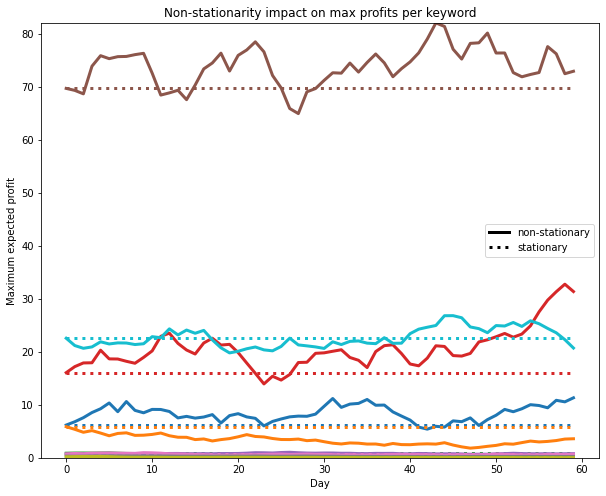

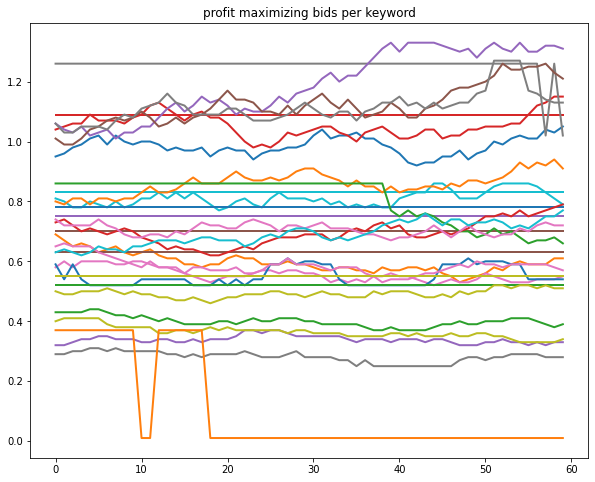

0


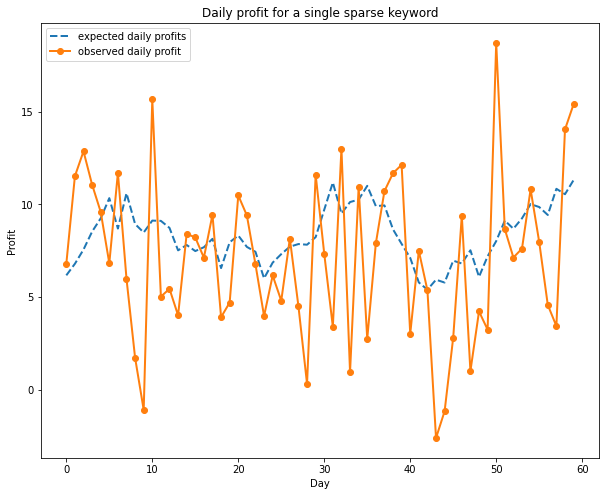

1


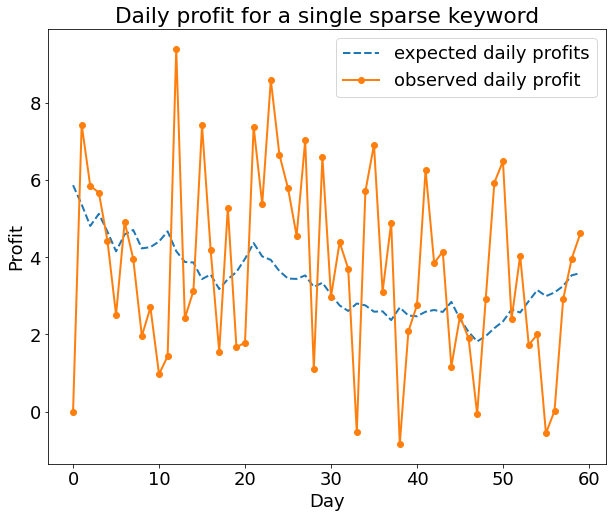

2


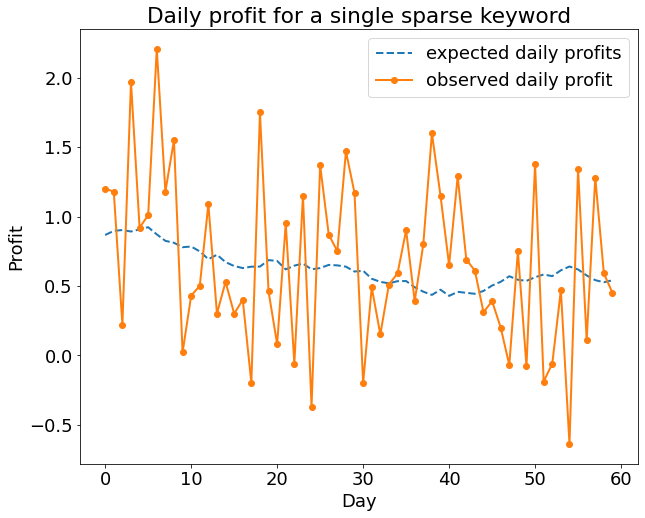

3


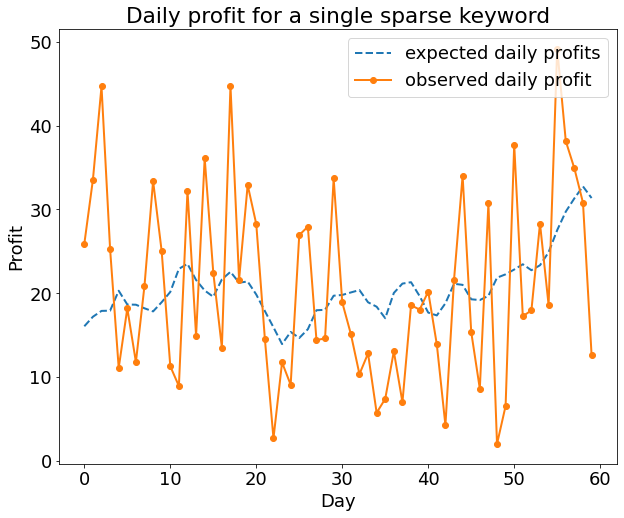

4


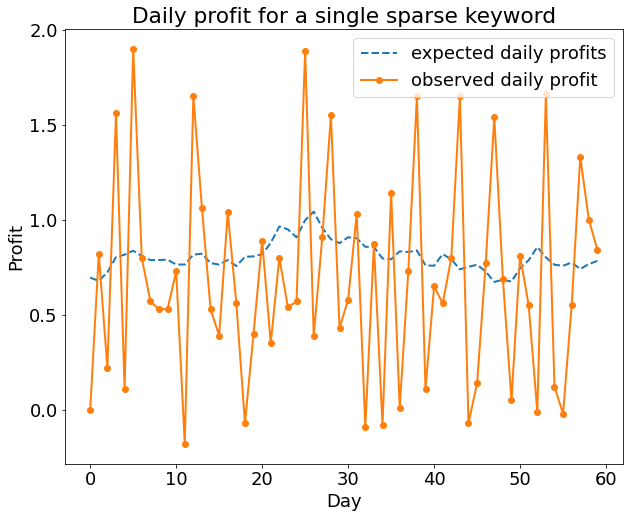

5


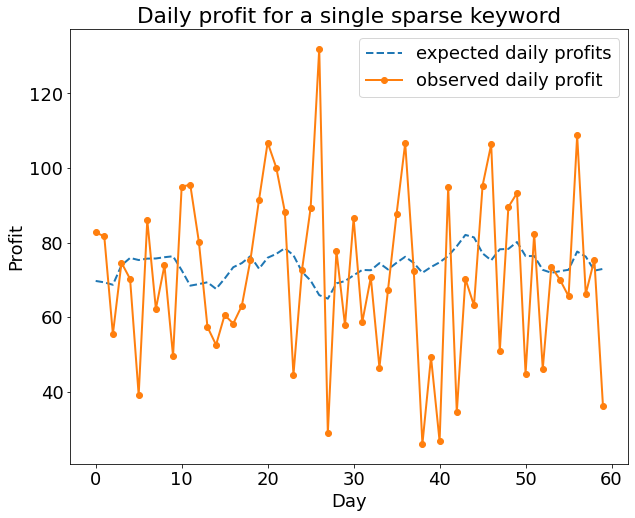

6


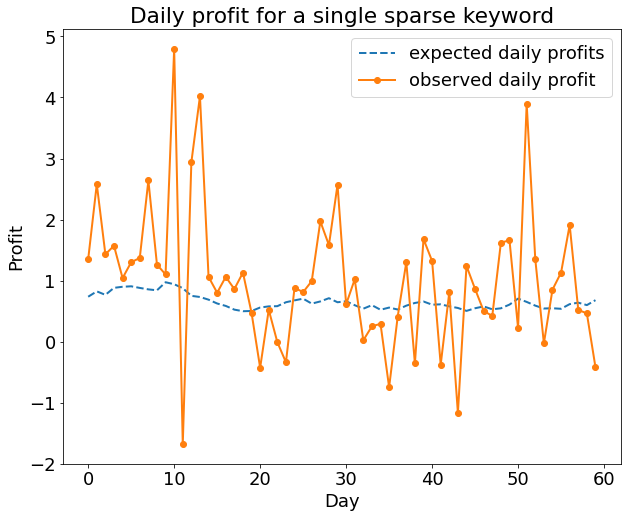

7


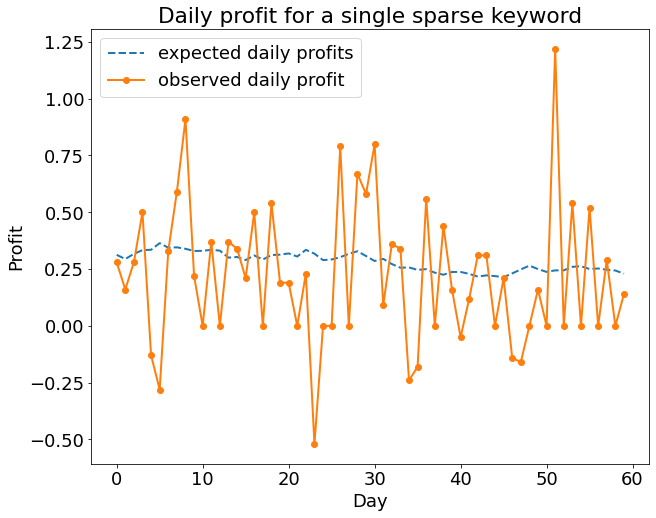

8


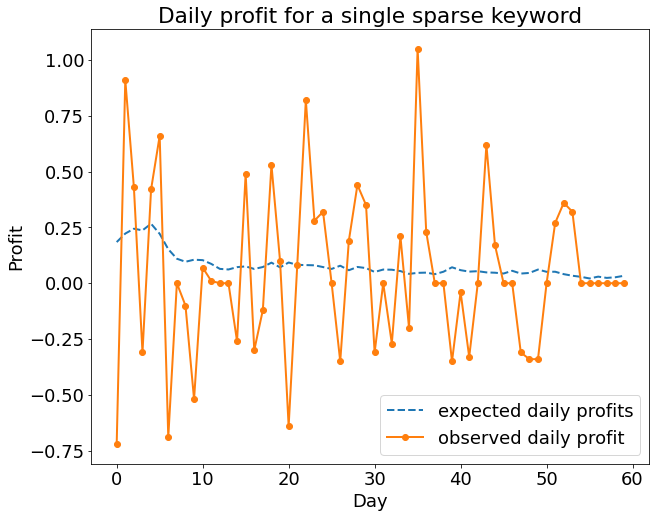

9


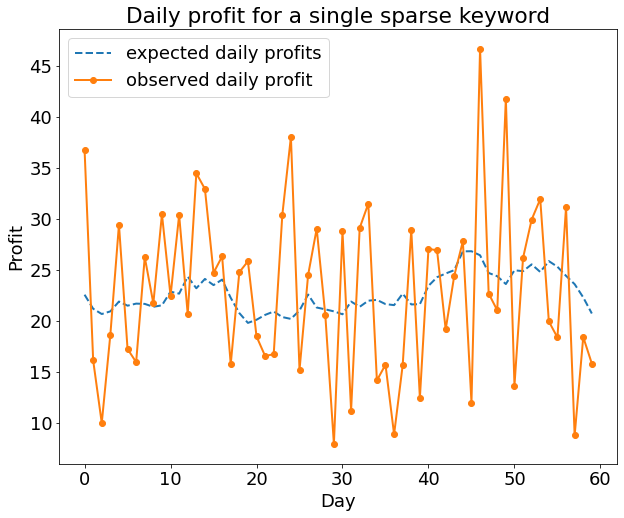

10


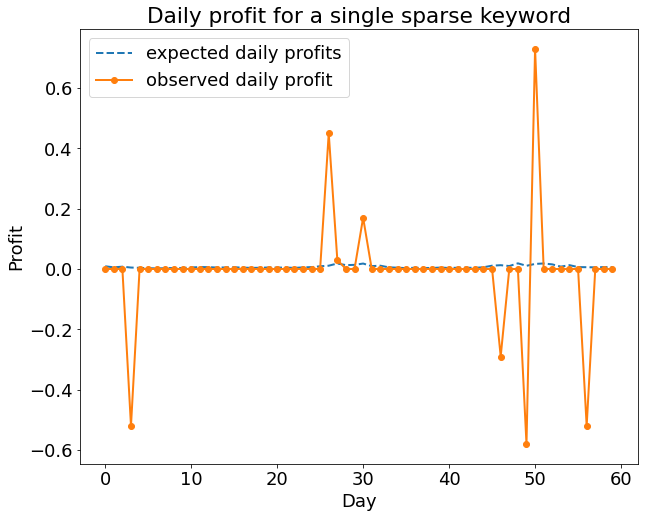

12


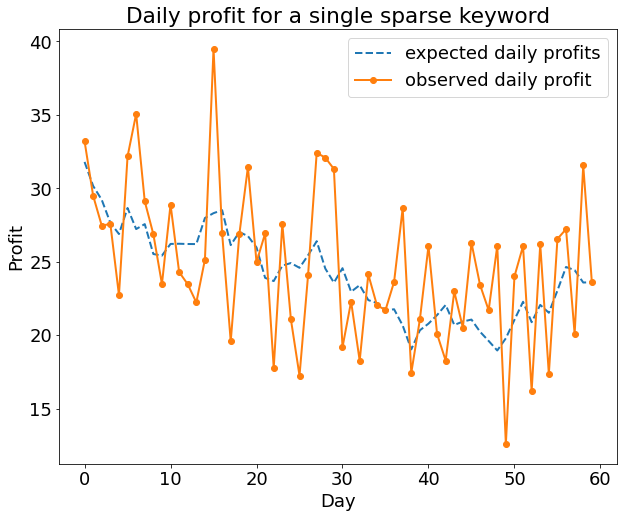

13


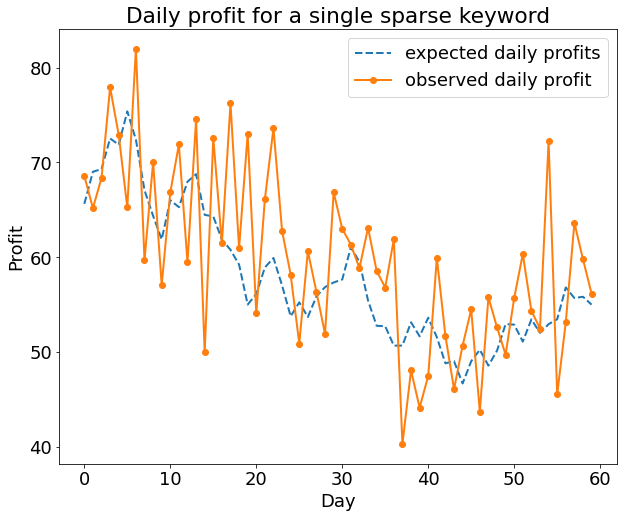

14


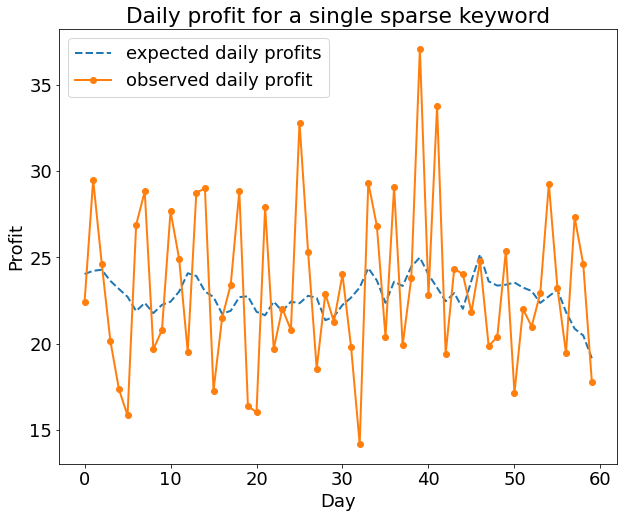

15


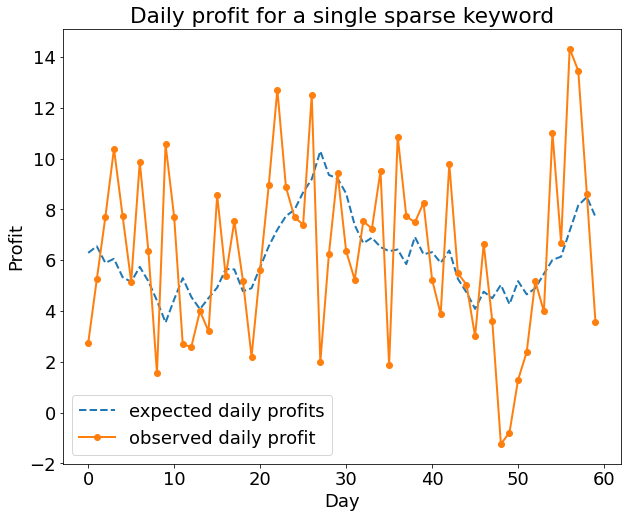

16


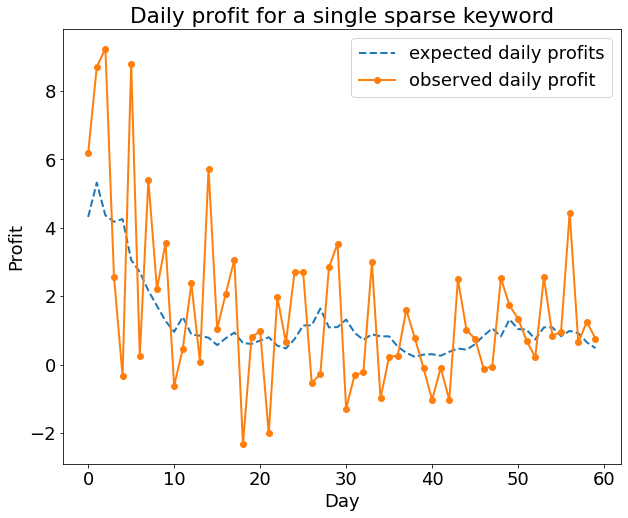

17


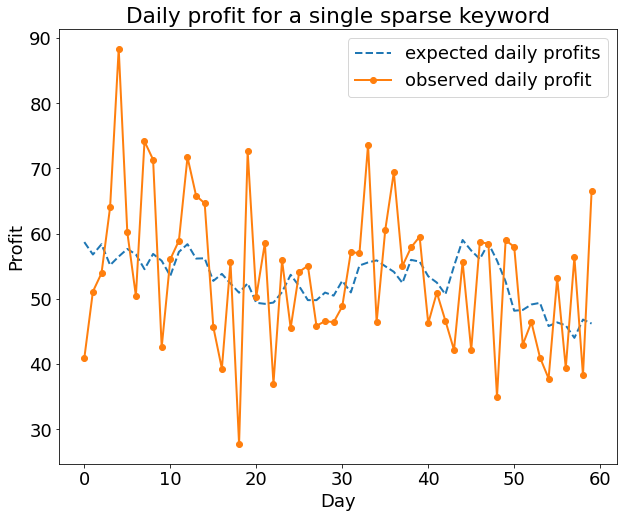

18


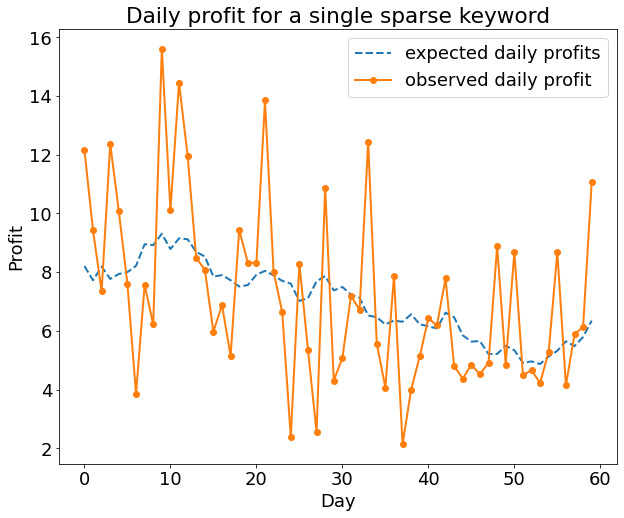

19


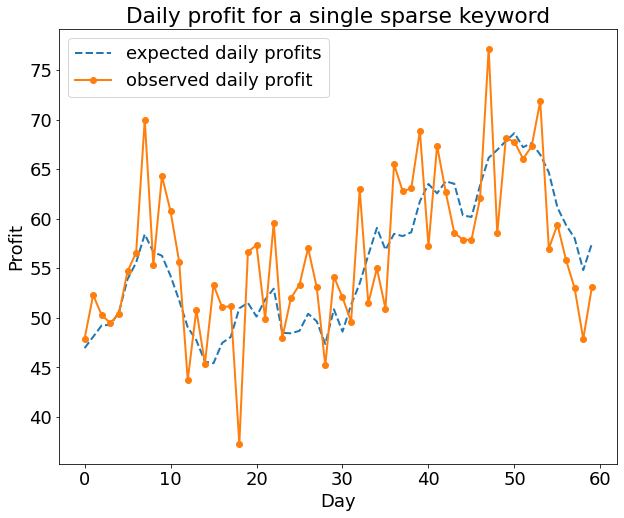

20


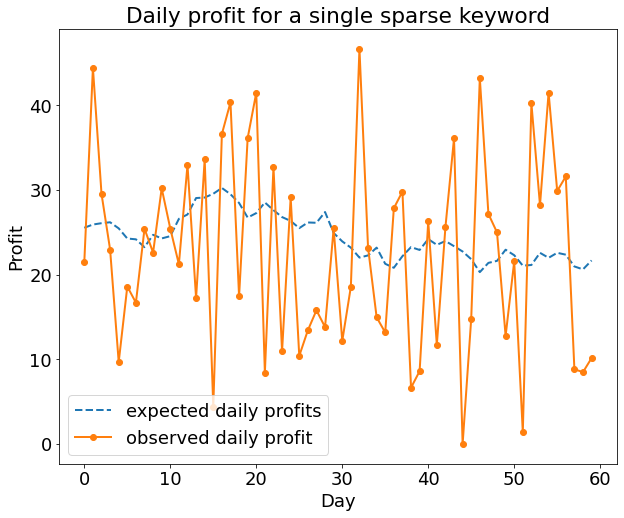

21


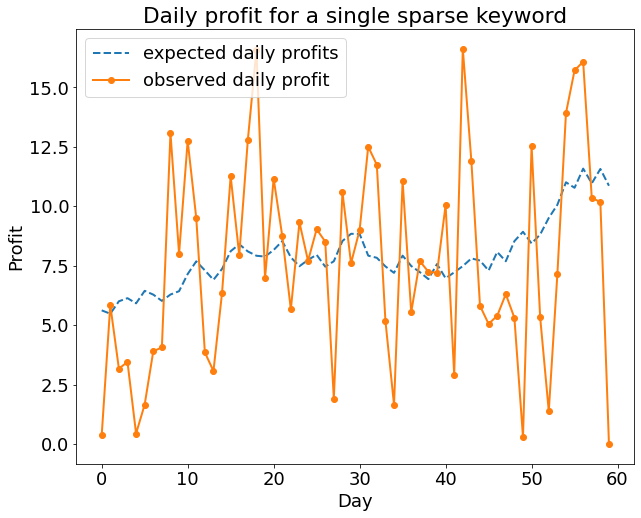

22


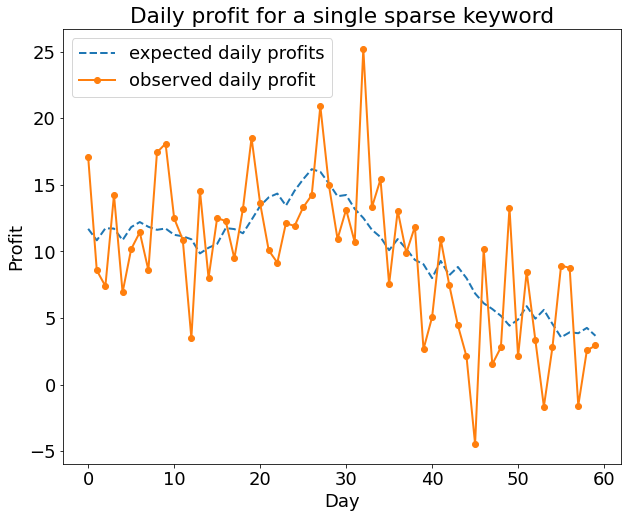

23


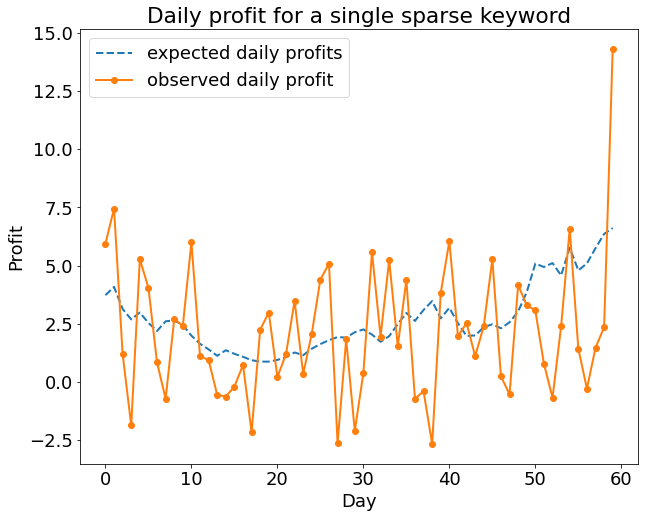

24


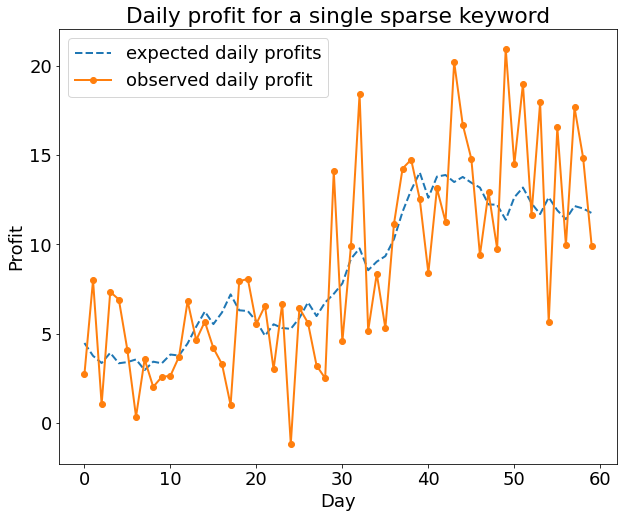

25


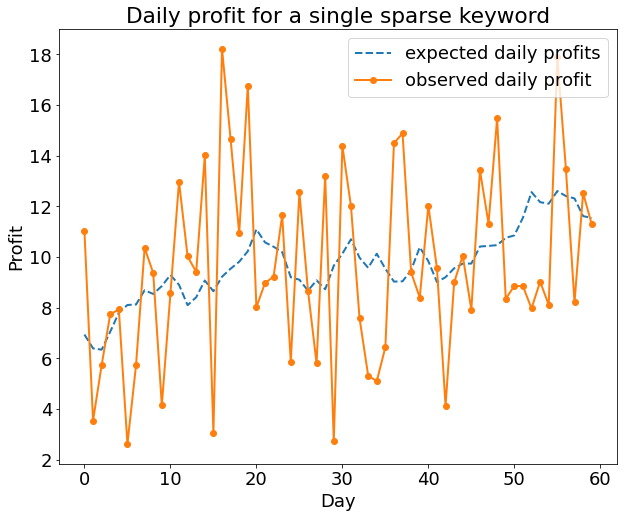

26


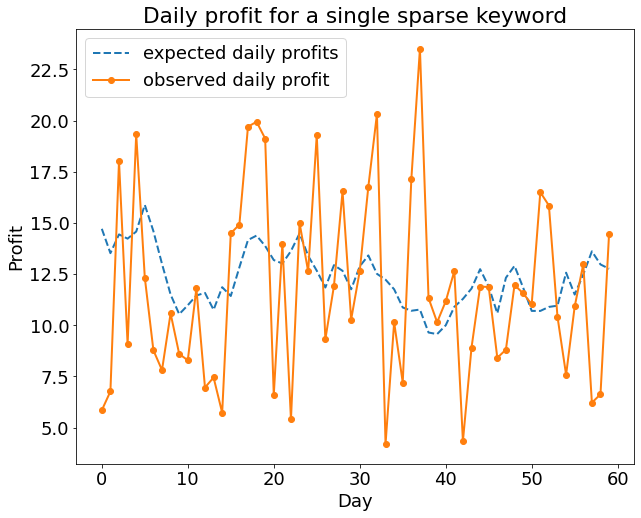

27


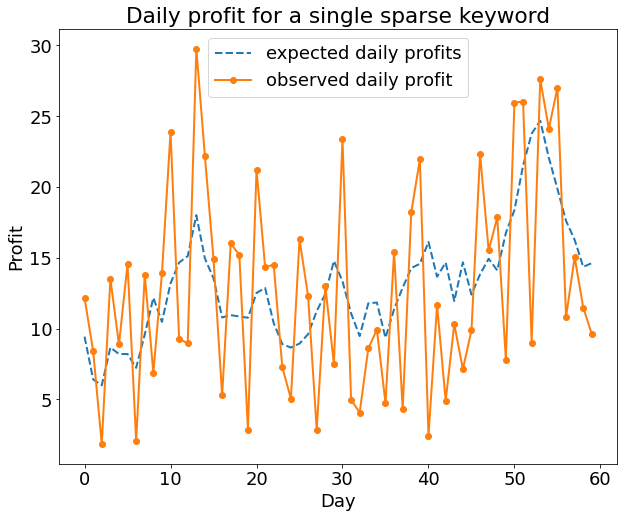

28


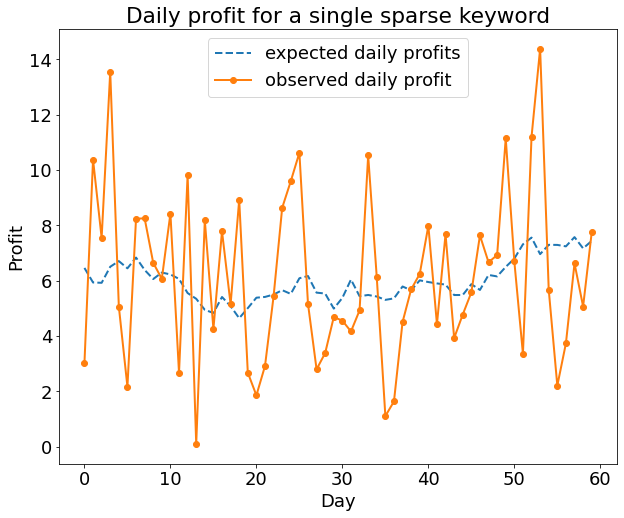

29


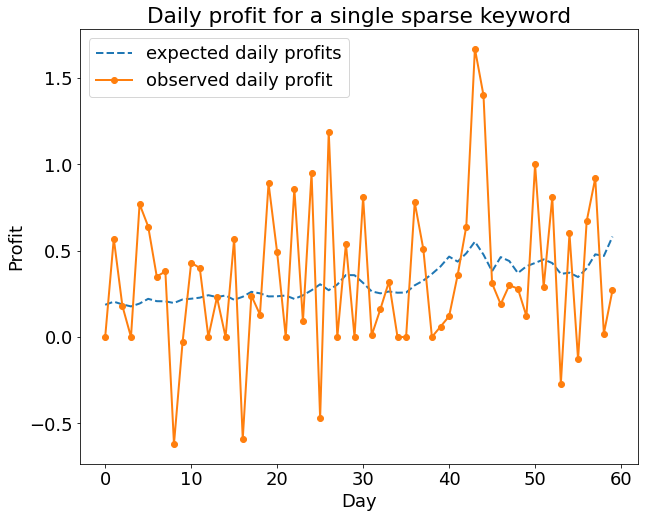

In [7]:
# Title/labels for the individual keywords are wrong for dense-nonstationary, but those plots didn't make it into the paper anyway
oracle_profits, ideal_profits, oracle_bids = get_nonstationary_profits(volume=128, cvr=0.8, num_keywords=30, time_steps=60, updater_params = [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]], env_seed=9, oracle=True)
show_kw_bid_results(oracle_profits, ideal_profits, 0, oracle_bids)

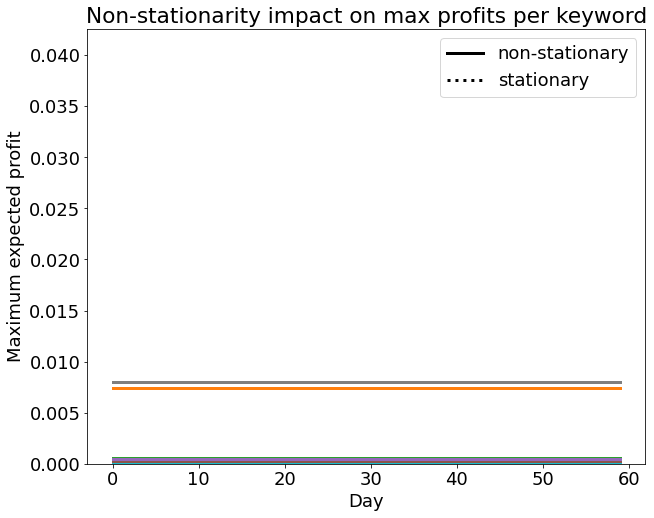

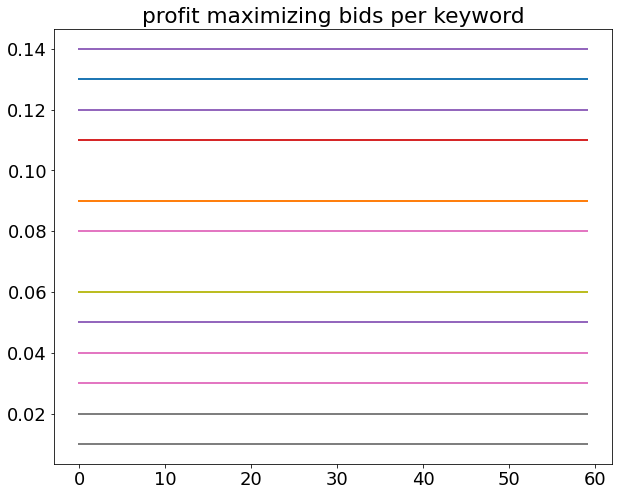

1


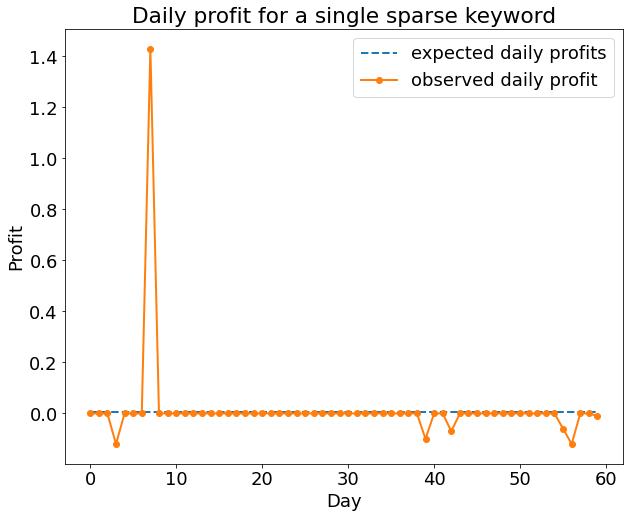

2


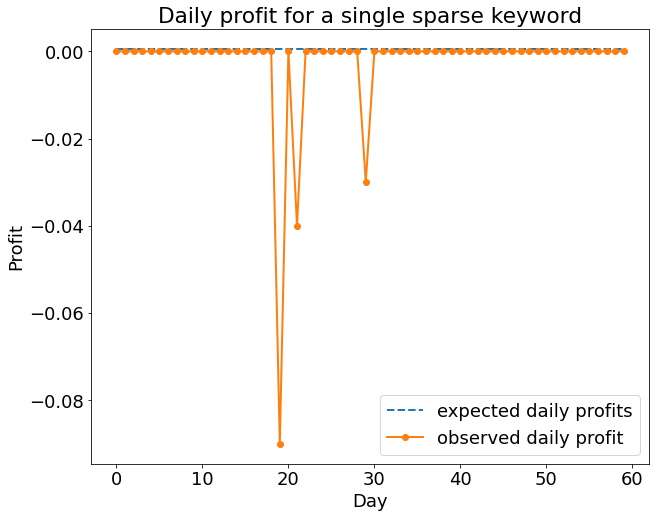

7


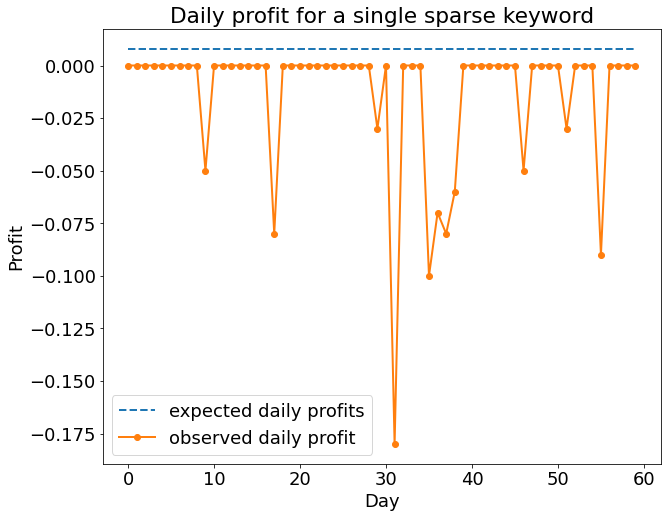

14


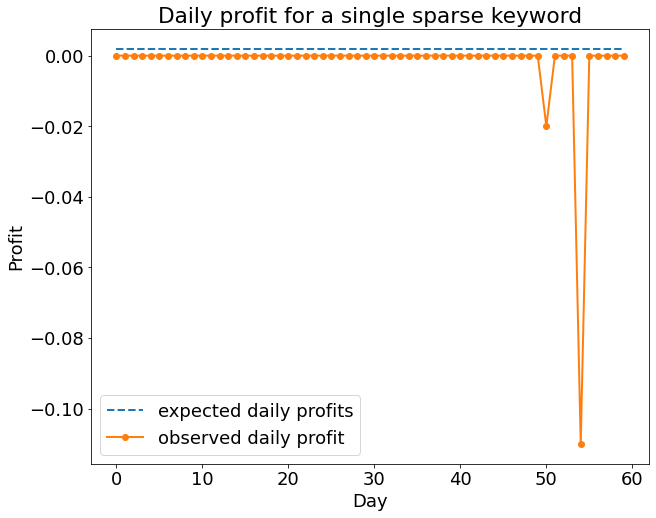

21


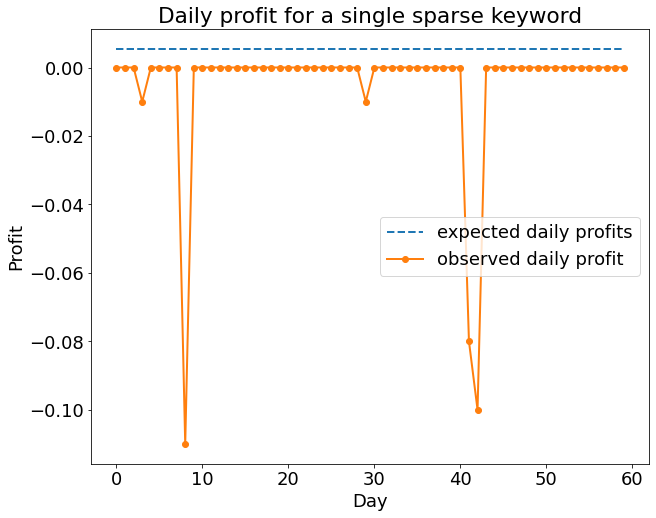

23


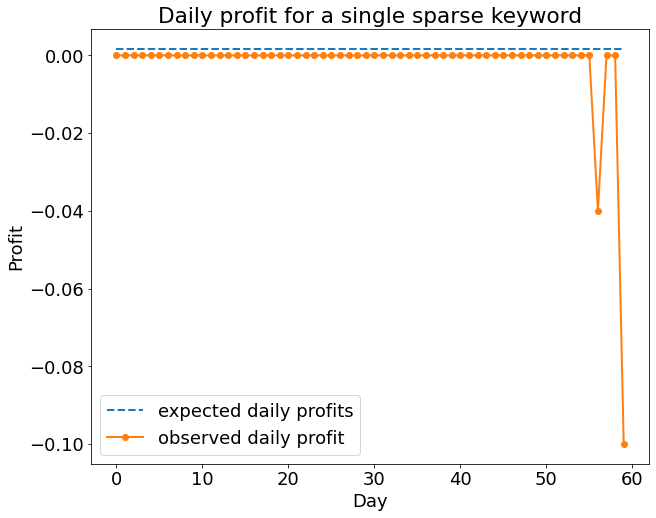

28


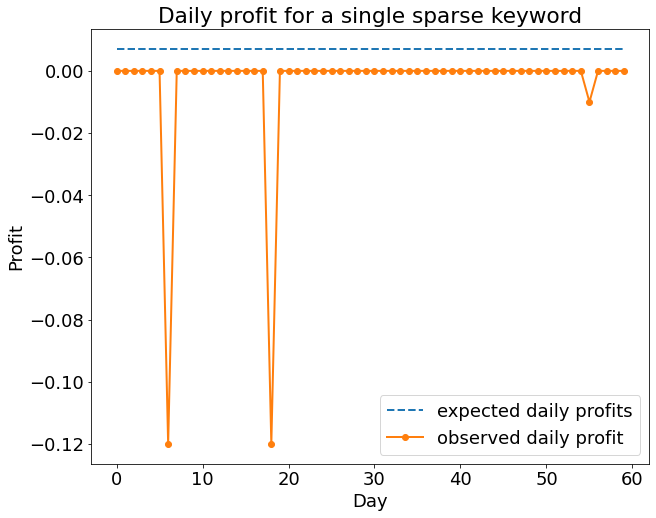

31


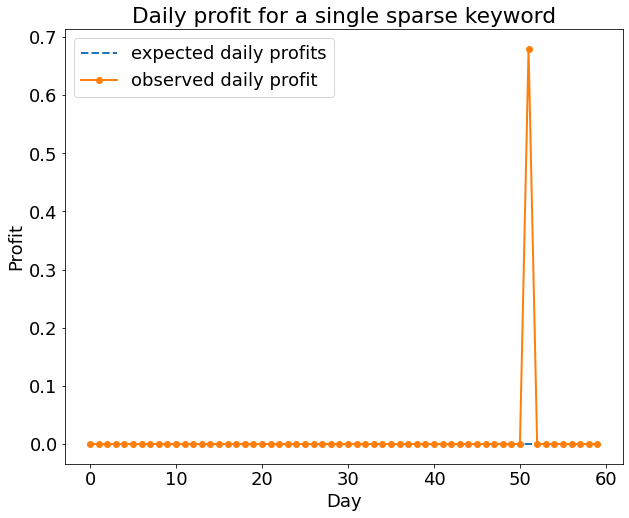

32


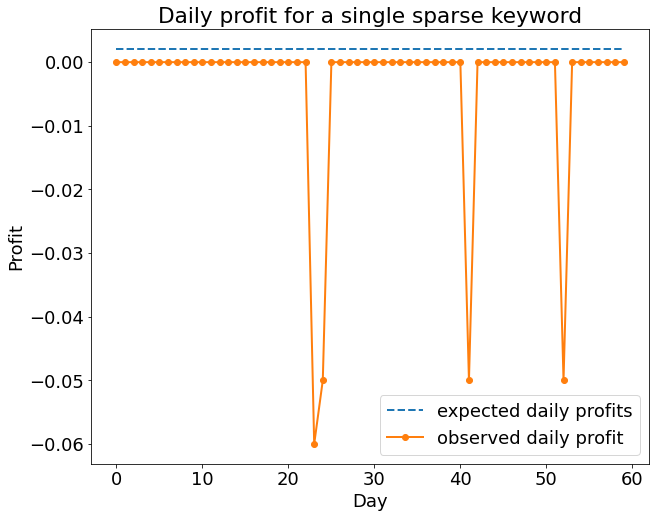

33


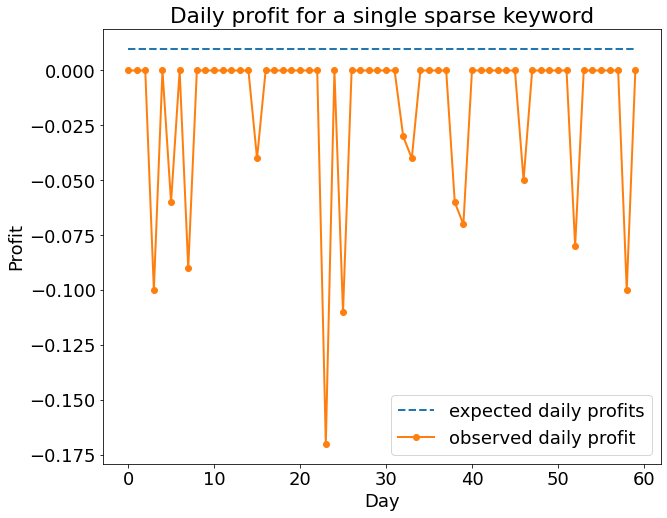

35


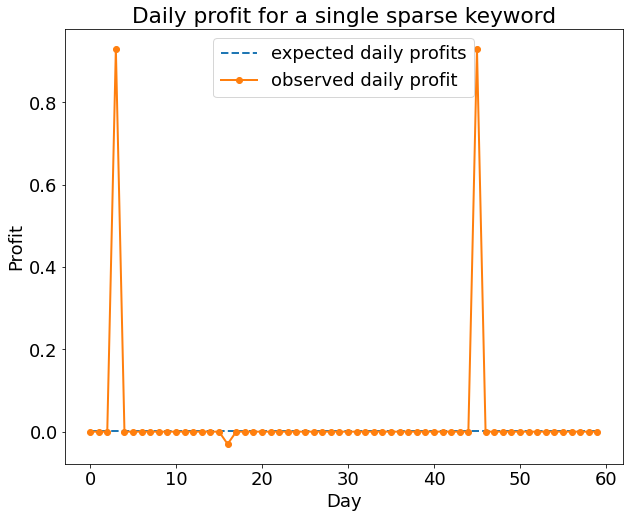

36


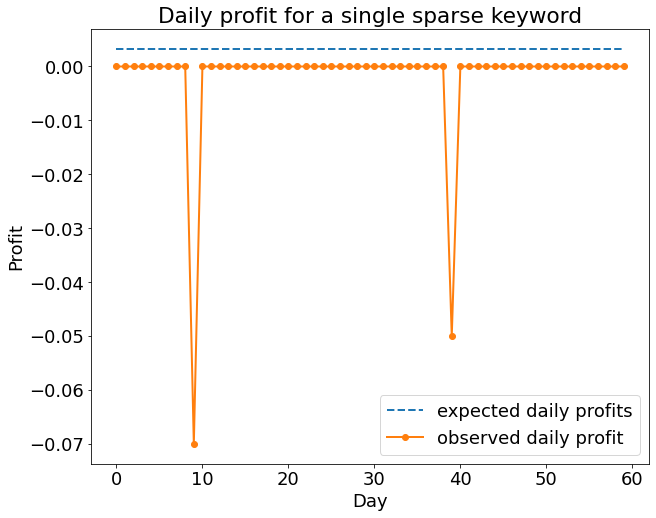

40


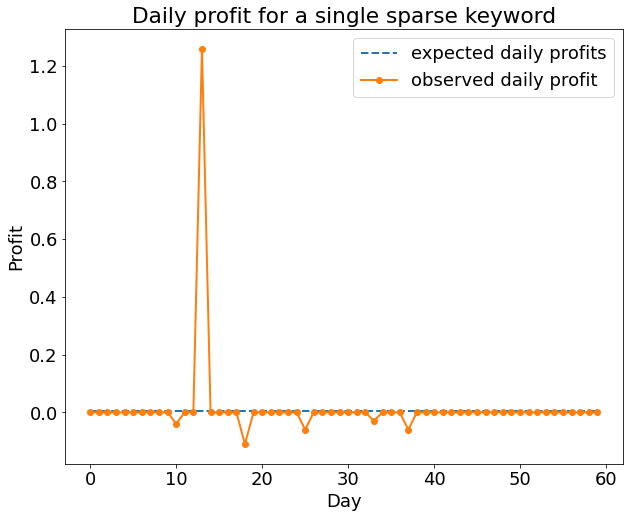

41


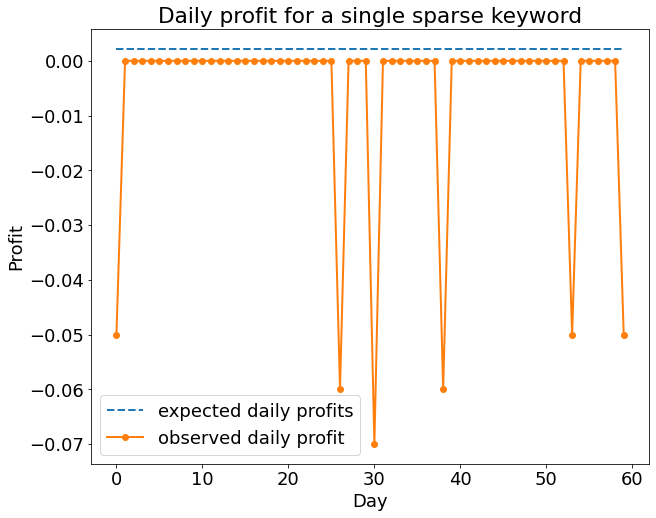

54


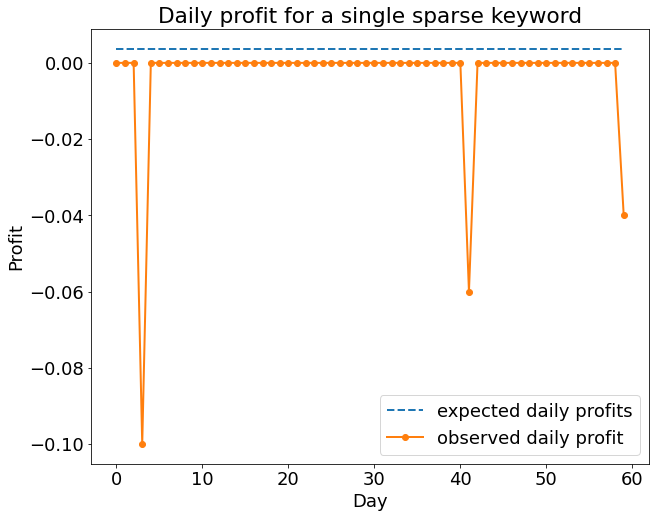

55


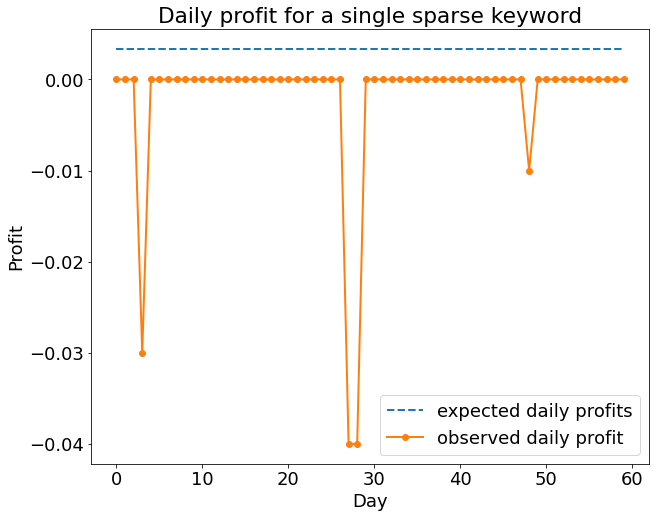

56


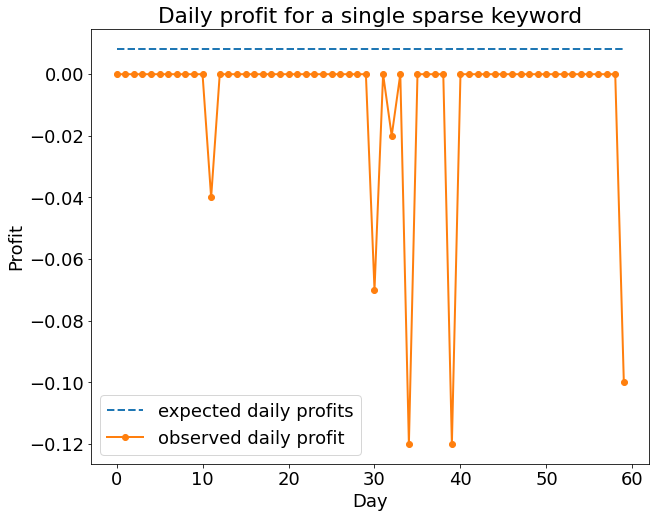

63


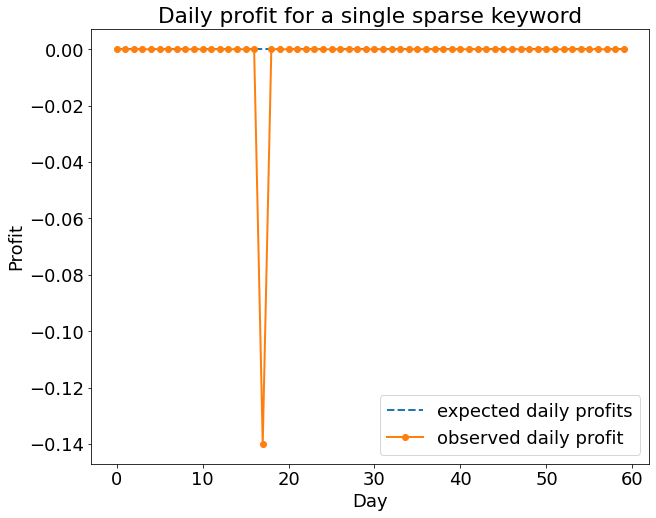

64


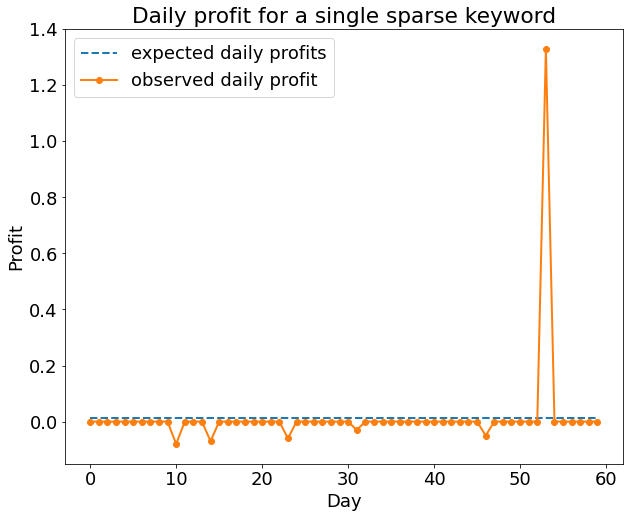

65


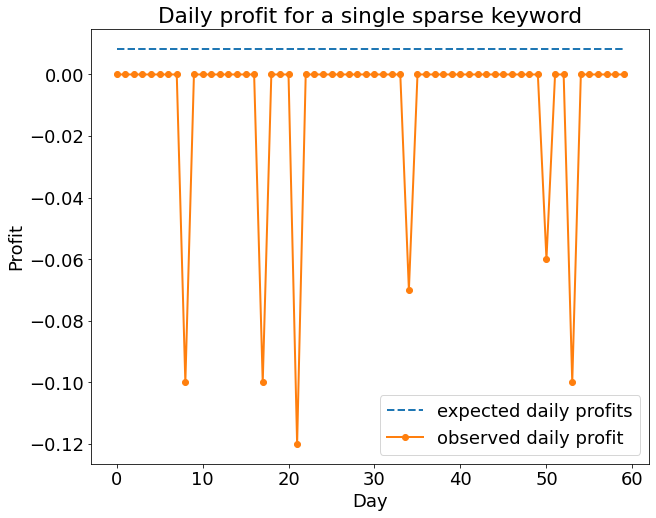

66


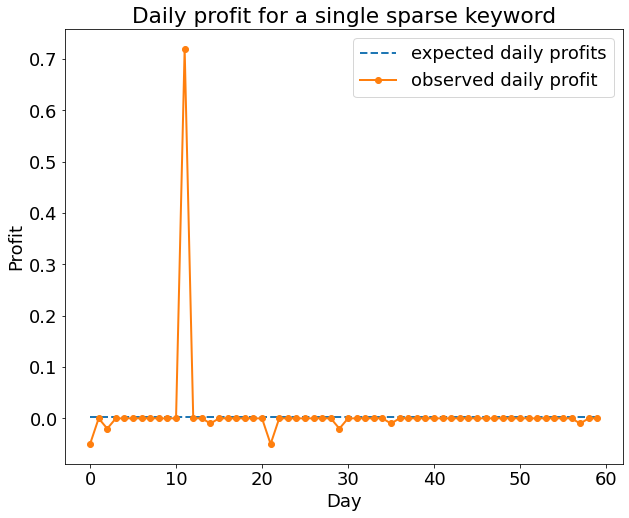

67


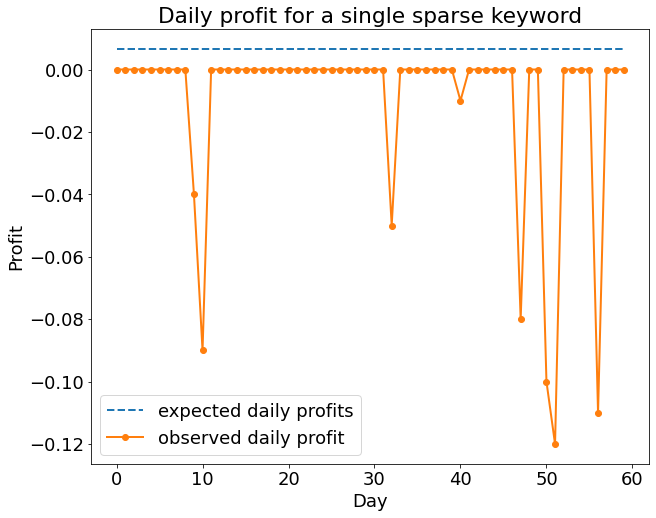

71


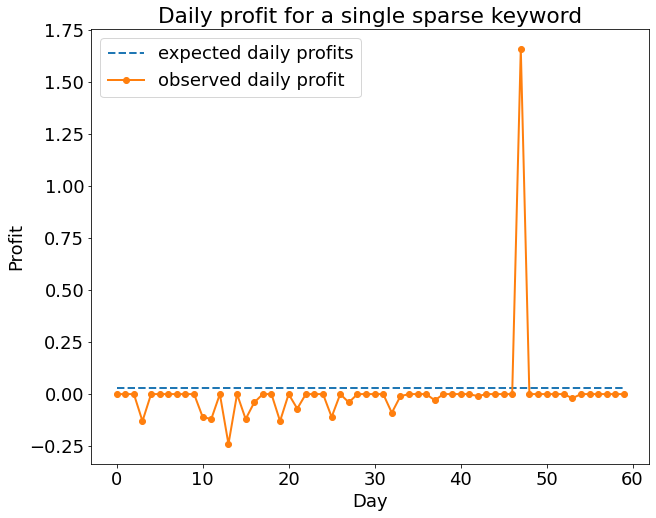

72


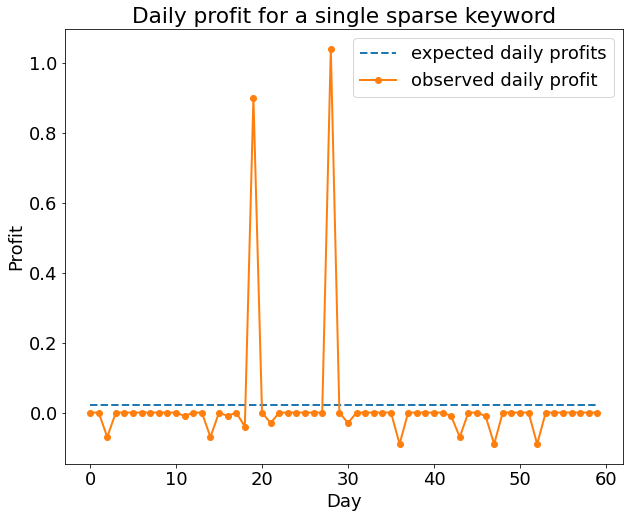

73


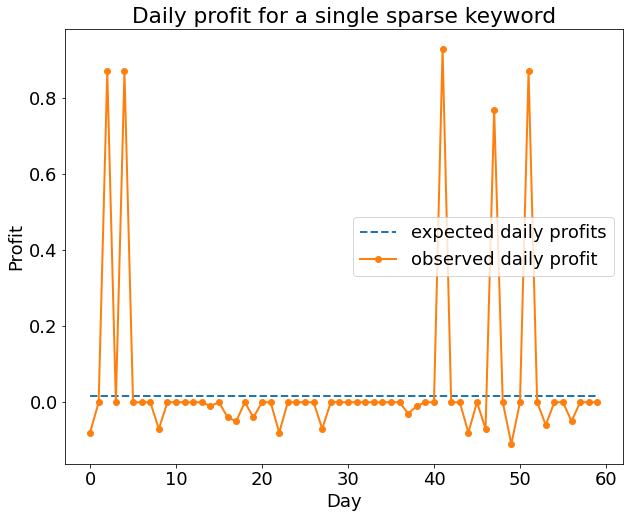

76


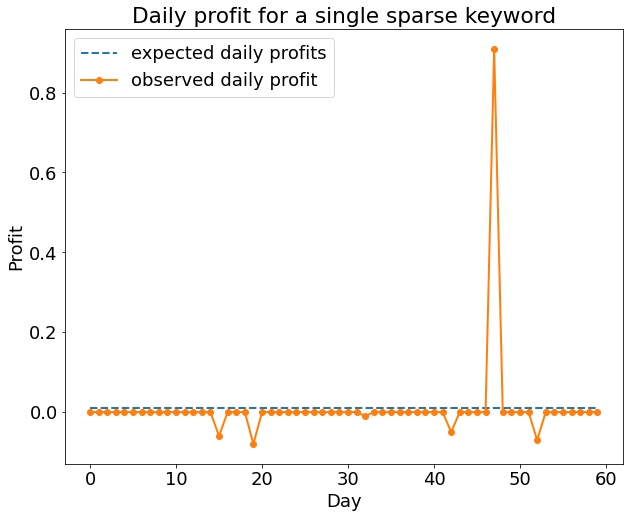

77


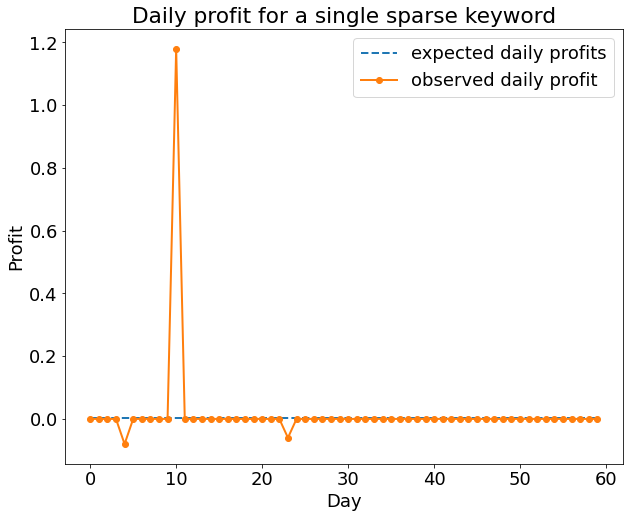

82


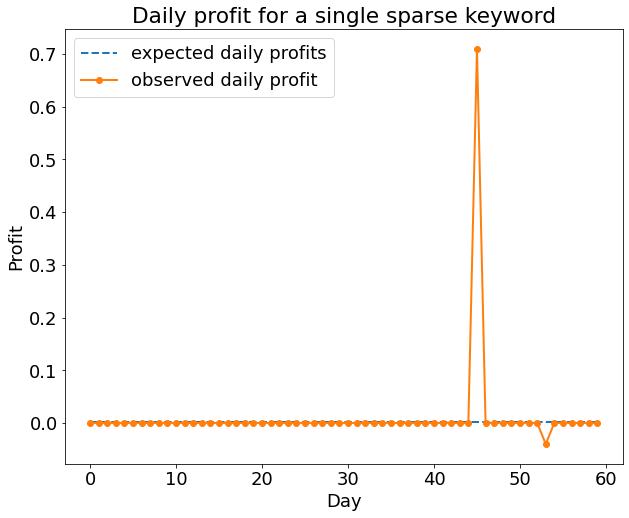

83


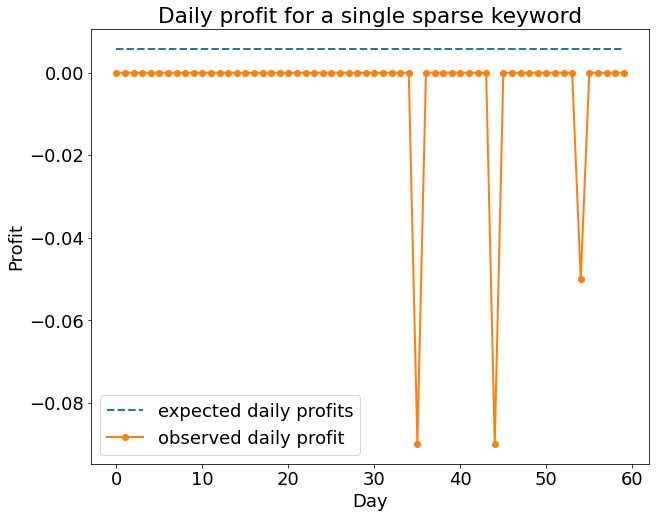

85


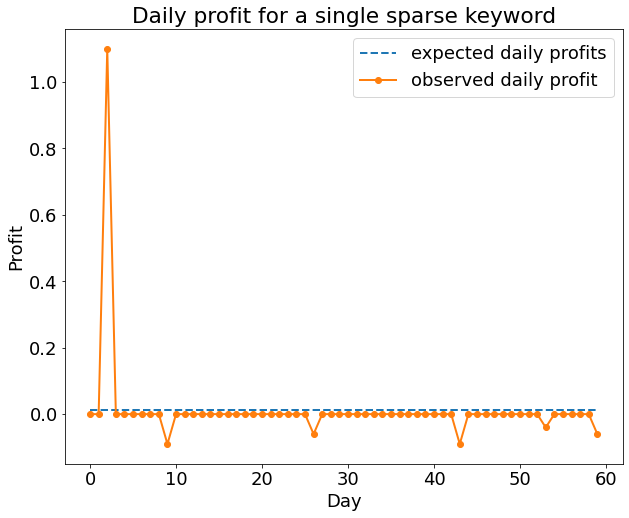

86


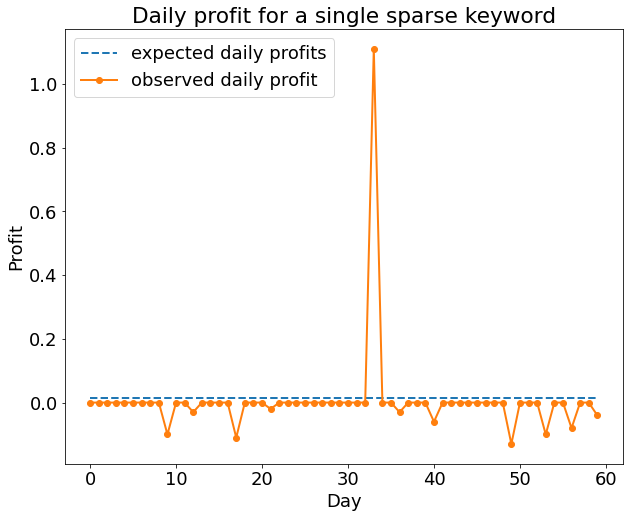

90


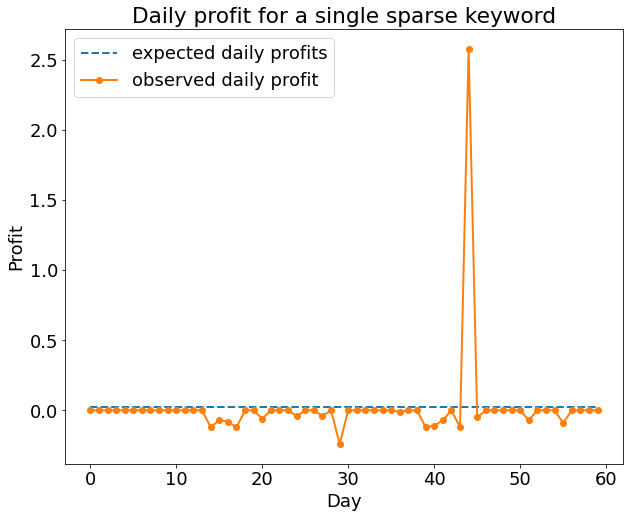

94


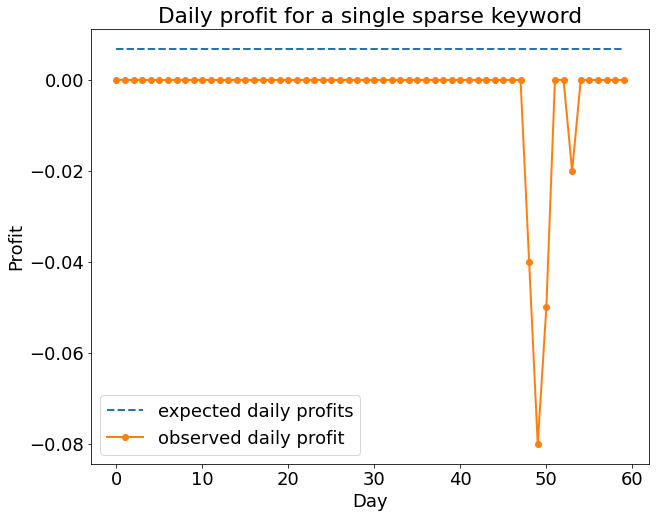

100


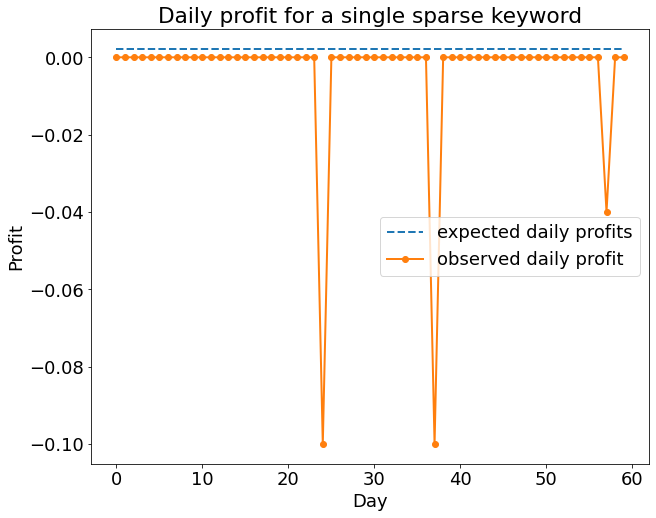

109


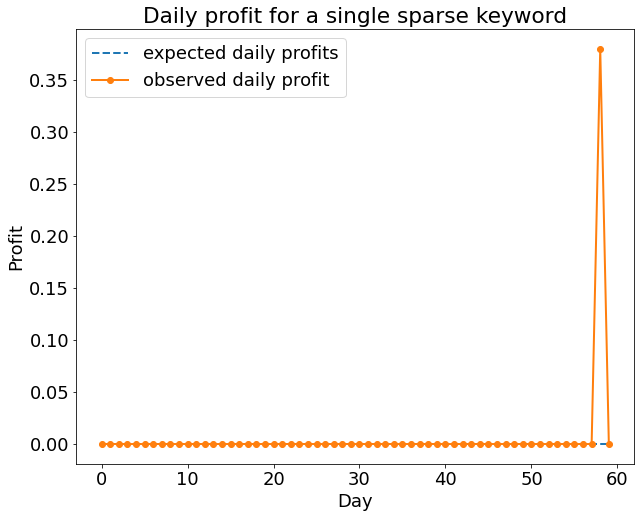

111


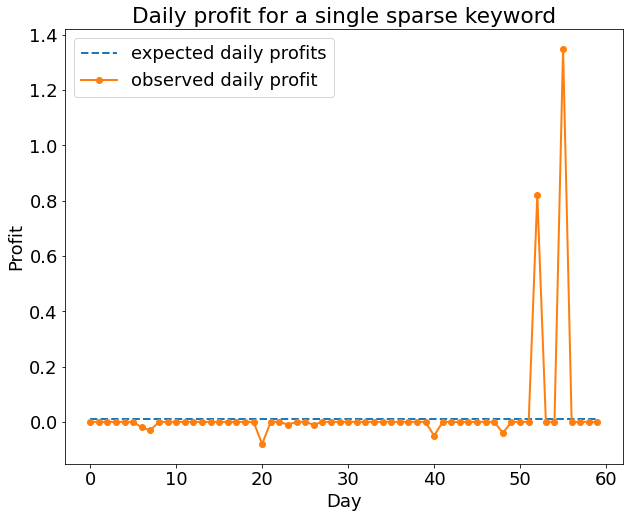

123


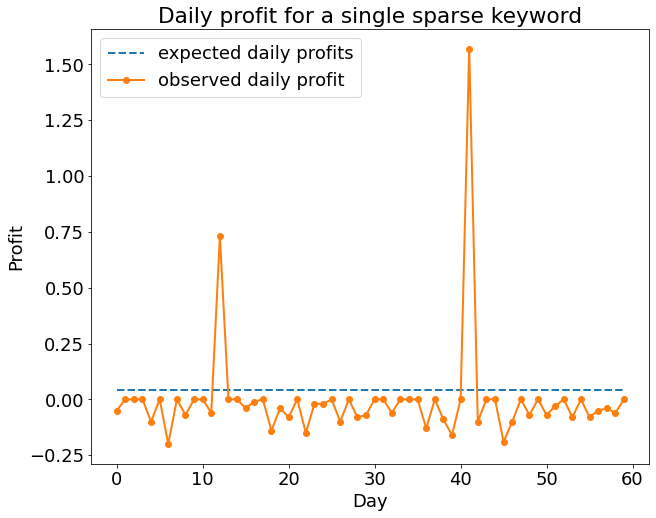

In [15]:
oracle_profits, ideal_profits, oracle_bids = get_stationary_profits(volume=16, cvr=0.1, num_keywords=128, time_steps=60, updater_params = [["vol", 0.03], ["ctr", 0.03], ["cvr", 0.03]], env_seed=9, oracle=True)
show_kw_bid_results(oracle_profits, ideal_profits, 0, oracle_bids)

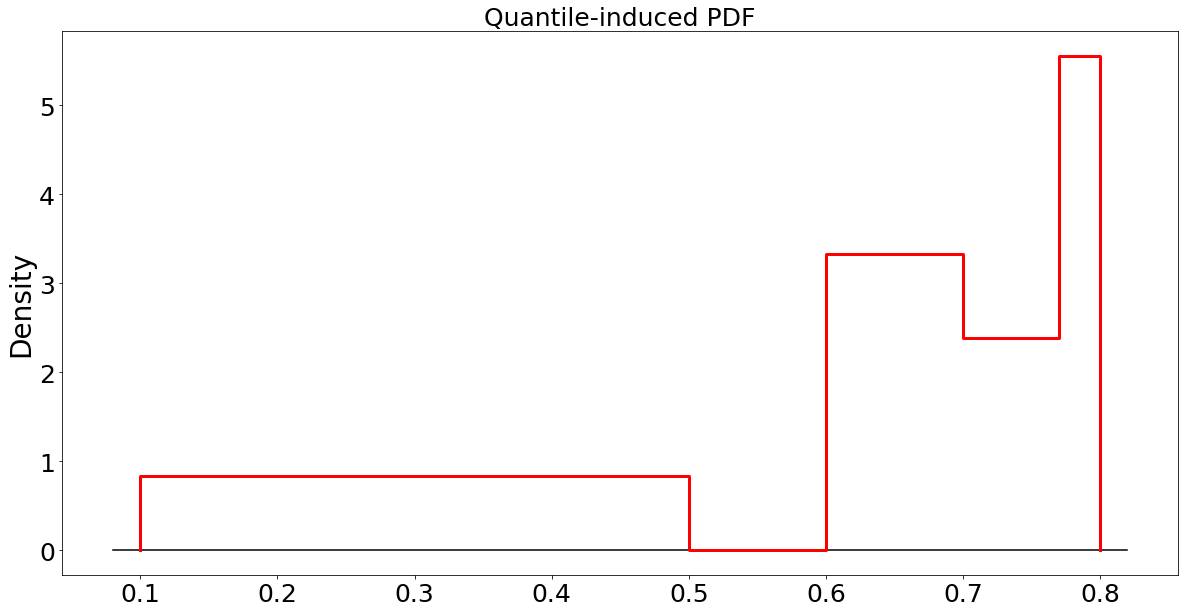

In [9]:
quantile_bins = [
    [0.1,0.3,0.5], 
    [0.6,0.65,0.7],
    [0.7,0.77,0.8],
    # [0.8,0.9,1.0]
]
plt.figure(figsize =(20,10))
bin_vol = 1/(2*len(quantile_bins))
xs, ys = [], []
for bins in quantile_bins:
    vol1 = bin_vol / (bins[1]-bins[0])
    vol2 = bin_vol / (bins[2]-bins[1])
    xs += [bins[0], bins[0], bins[1], bins[1], bins[2], bins[2]]
    ys += [0, vol1, vol1, vol2, vol2, 0]

# remove bounces down to 0
done = False
start = 0
while not done:
    index = start
    for x, y in zip(xs[start+1:-1], ys[start+1:-1]):
        prev_x = xs[index]
        next_x = xs[index+2]
        if prev_x == next_x and y == 0:
            xs.pop(index+1)
            ys.pop(index+1)
            start = index
            break
        index += 1
    if index == len(xs)-2:
        done = True
# plot pdf
plt.plot([-0.02+min(xs),max(xs)+0.02],[0,0],'k')
plt.plot(xs, ys, 'r',label='Quantile-induced PDF', linewidth=3)

plt.rcParams.update({'font.size': 25})
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=28)     # fontsize of the x and y labels
plt.ylabel('Density')
# plt.xlabel('x')
plt.title('Quantile-induced PDF')
plt.show()